# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель проекта** - построить модель для предсказания количества такси на следующий час.


Заранее установлен критерий качества модели:

- Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Для исследования предоставлена таблица `taxis.csv` с количеством заказов относительно времени.

Этапы исследования:
1. Обзор данных
2. Предобработка данных
3. Разведочный анализ данных
4. Подбор модели и прогнозирование
5. Интерпретация результатов и выводы

## 1. Обзор данных 

Импортируем библиотеки, скачаем данные и посмотрим их и оценим соответствуют ли они задаче. 

In [0]:
import os
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ydata_profiling import ProfileReport
from scipy.special import boxcox, inv_boxcox
from scipy import stats

%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder , StandardScaler, OrdinalEncoder
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import lightgbm as lgb

from datetime import date

RANDOM_STATE = 42
sns.set_palette("pastel")

In [1]:
if os.path.exists('taxi.csv'):
    taxi = pd.read_csv('taxi.csv')
elif os.path.exists('/datasets/taxi.csv'):
    taxi = pd.read_csv('/datasets/taxi.csv')
else:
    print('Something is wrong')

In [2]:
ProfileReport(taxi)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Вывод
- Таблица состоит из двух столбцов - временная метка и количество заказов такси в это время. 
- В таблице 26496 записей.
- Данные соответсвуют описанию задачи

## 2. Предобработка данных

- изменим тип временной отметки на datetime, чтобы продолжить с ней работать в соответсвующем ключе.

In [3]:
taxi.datetime = pd.to_datetime(taxi.datetime)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
taxi.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


Сделаем временную отметку индексом временного ряда. 

In [6]:
taxi.set_index('datetime', inplace=True)
taxi.sample()

,num_orders
datetime,
2018-04-08 09:10:00,9


Посмотрим упорядочен ли ряд.

In [7]:
print(taxi.index.is_monotonic_decreasing)
print(taxi.index.is_monotonic_increasing)

False
True


<Axes: title={'center': 'Изменение количества поездок со временем'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

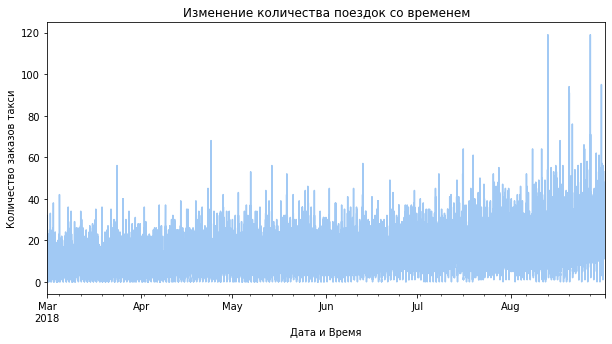

In [8]:
taxi.plot(title='Изменение количества поездок со временем',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    legend=False,
    figsize=(10,5))

Ряд монотонно возрастает, временные отметки упорядочены.

- Сделаем ресемплирование по одному часу, т.к. нас интересует количество заказов в час.

<Axes: title={'center': 'Изменение количества поездок по часам'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

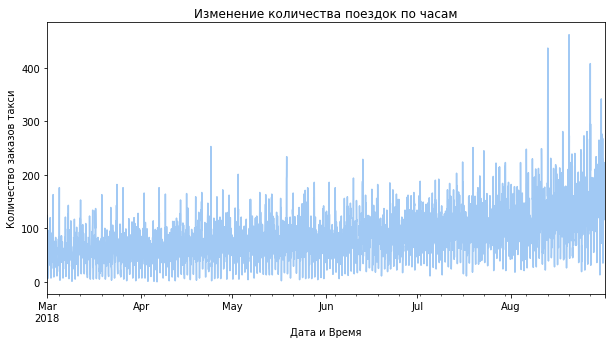

In [9]:
taxi = taxi.resample('1H').sum()
taxi.plot(title='Изменение количества поездок по часам',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    legend=False,
    figsize=(10,5))

### Вывод по предобработке
- в данных нет пропусков и дубликатов
- изменили тип данных временной отметки на datetime
- ряд монотонно возрастает, временные отметки упорядочены.
- сделали ресемплирование временного ряда по одному часу (в каждой группе считали сумму значений)


## 3. Разведочный анализ временного ряда

- оценим тренд и сезонность изменения количество заказов такси

<Axes: title={'center': 'Изменение количества поездок - среднее по суткам'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

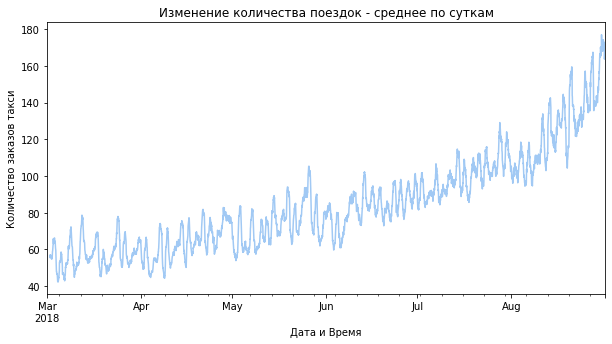

In [10]:
taxi.rolling(24).mean().plot(title='Изменение количества поездок - среднее по суткам',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    legend=False,
    figsize=(10,5))


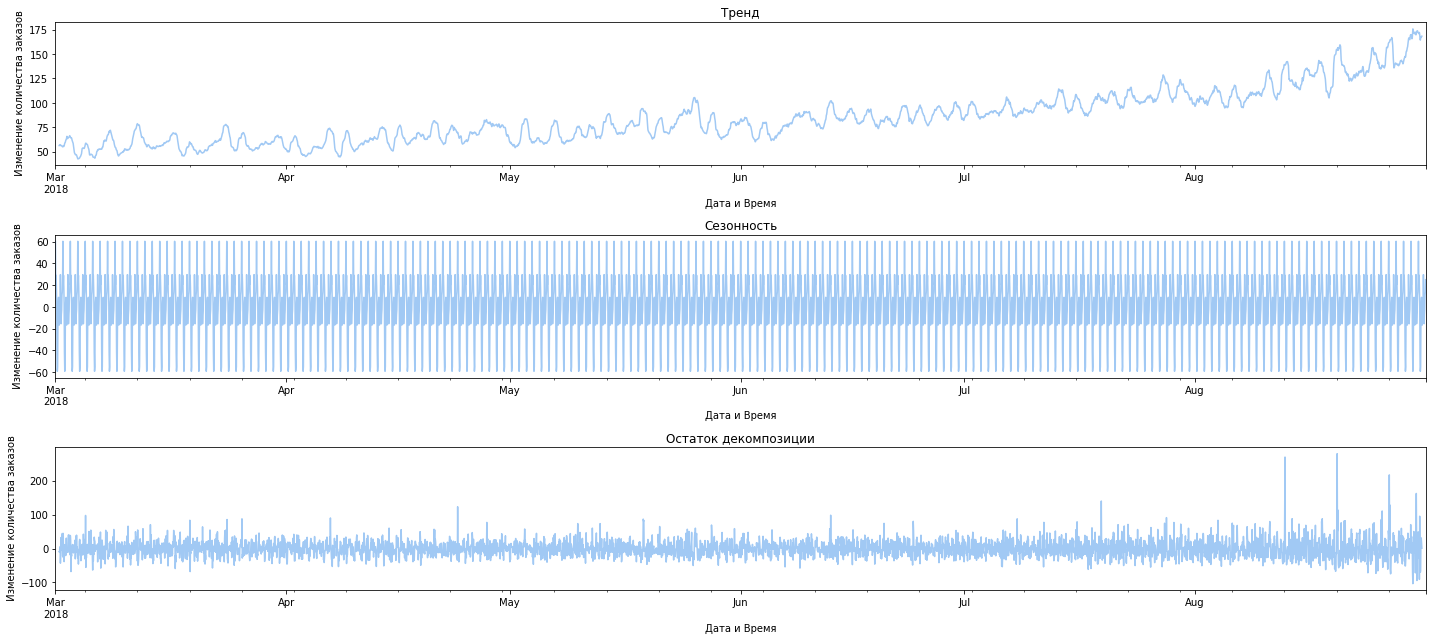

In [11]:
decomposed = sm.tsa.seasonal_decompose(taxi)

plt.figure(figsize=(20, 9))
plt.subplot(311) 
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.tight_layout()

- Имеется тренд к росту числа заказов такси из аэропорта с марта по август 2018 года.
- Имеются повторяющиеся закономерности в масштабе суток: пик заказов наблюдается ночью - точнее в полночь, минимальное число заказов такси из аэропорта - рано утром , около 6 утра. Эта закономерность может быть связана, например, с режимом работы общественного транспорта (ночью ходит реже или вообще не ходит) или предпочтениями пассажиров к времени прилета при выборе рейсов.

<Axes: title={'center': 'Закономерности изменения числа заказов 1-2 марта 2018'}, xlabel='Дата и Время', ylabel='Количество заказов такси '>

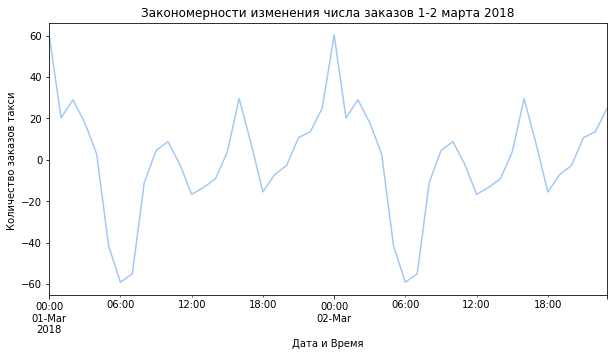

In [12]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(title='Закономерности изменения числа заказов 1-2 марта 2018',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси ',
    legend=False,
    figsize=(10,5))


### Автокорреляция

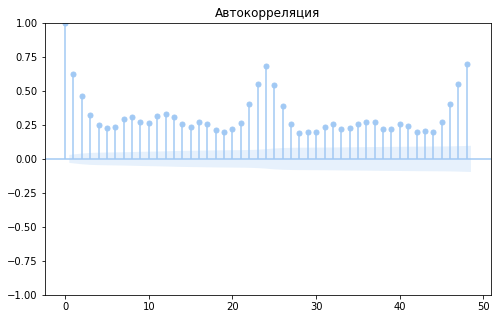

In [13]:
plt.figure(figsize=(8,5))
sm.graphics.tsa.plot_acf(taxi,ax=plt.gca(), 
                         lags =48)
plt.title('Автокорреляция')

plt.show()

### Тесты на стационарность 

Возьмем уровень значимости 0.01.


In [14]:
# критерий КПСС
result = sm.tsa.stattools.kpss(taxi, regression='c')
print('P-value:', result[1])

P-value: 0.01


C:\Users\very-\AppData\Local\Temp\ipykernel_13940\1928711797.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = sm.tsa.stattools.kpss(taxi, regression='c')


Согласно критерию КПСС ряд не стационарен.

In [15]:
result = sm.tsa.stattools.adfuller(taxi)
print('P-value:', result[1])


P-value: 0.0289400514026128


Согласно критерию Дики Фуллера ряд не стационарен.

### Преобразование ряда 

Попробуем сделать ряд стационарным.

Сперва продифференцируем, чтобы убрать тренд.

In [16]:
dif_taxi_with_na = taxi.shift(1) - taxi
dif_taxi = dif_taxi_with_na.dropna()

<Axes: title={'center': 'Изменение количества поездок по часам'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

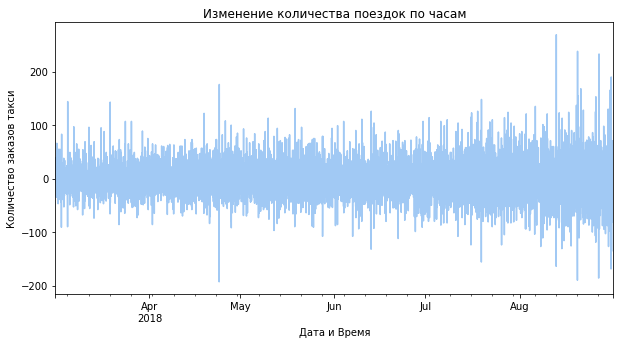

In [17]:
dif_taxi.plot(title='Изменение количества поездок по часам',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    legend=False,
    figsize=(10,5))

Снова применим тест Дики-Фуллера:

In [18]:
result = sm.tsa.stattools.adfuller(dif_taxi)
print('P-value:', result[1])

P-value: 1.0958776746509003e-28


P-value сильно меньше 0.01, значит, отвергая Н0, принимаем, что ряд стационарный.

Воспользуемся еще преобразованием Бокса-Кокса, что достичь гомоскедастичности (равенства дисперсий на всем протяжении ряда)

Оптимальный параметр преобразования Бокса-Кокса: -0.323154


C:\Users\very-\AppData\Local\Temp\ipykernel_13940\3005324910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dif_taxi['num_orders_box'], lmbda = stats.boxcox([1 if (x <= 0)  else x for x in dif_taxi.num_orders])


Критерий Дики-Фуллера: p=0.000000


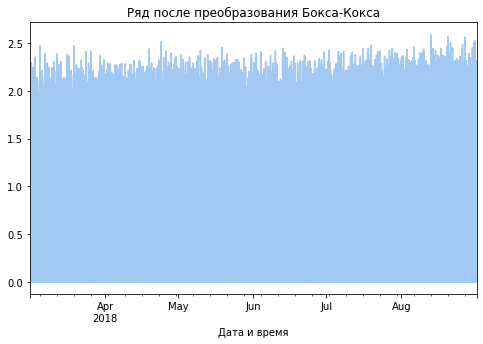

In [19]:
dif_taxi['num_orders_box'], lmbda = stats.boxcox([1 if (x <= 0)  else x for x in dif_taxi.num_orders])
dif_taxi.num_orders_box.plot(figsize=(8,5))
plt.title(u'Ряд после преобразования Бокса-Кокса')
plt.xlabel(u'Дата и время')


print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(dif_taxi.num_orders_box)[1])

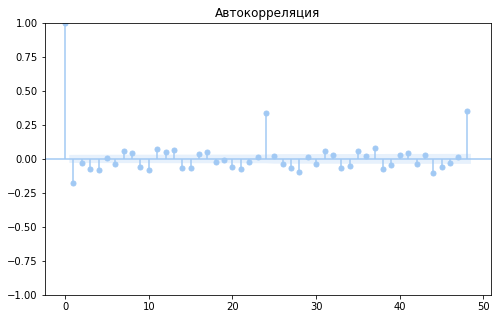

In [20]:
plt.figure(figsize=(8,5))
sm.graphics.tsa.plot_acf(dif_taxi.num_orders_box,ax=plt.gca(), 
                         lags =48)
plt.title('Автокорреляция')
plt.show()

### Вывод по анализу
- Представлены данные с марта по август 2018 года. 
- Имеется тренд к росту числа заказов такси из аэропорта с марта по август 2018 года.
- Имеются повторяющиеся закономерности в масштабе суток: пик заказов наблюдается ночью - точнее в полночь, минимальное число заказов такси из аэропорта - рано утром , около 6 утра. Эта закономерность может быть связана, например, с режимом работы общественного транспорта (ночтю ходит реже или вообще не ходит) или предпочтениями пассажиров к времени прилета при выборе рейсов.
- Исходный ряд нестационарен (согласно Критерию Дики-Фуллера)
- Ряд преобразовали - проинтегрировали и сделали преобразование Бокса-Кокса. Ряд стал стационарным.

## 4. Обучение модели и предсказание

Нам необходимо решить задачу регрессии.

Цель по качеству модели - Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Таргет - количества заказов такси в аэропорте за час.

Сначала попытаемся сделать классическую модель (не из библиотеки statsmodels), для этого нам нужно добавить данных.

### 4.1 Классичсекие модели - Подготовка данных

В качестве входных признаков (их надо добавить) будем использовать день недели, месяц, день месяца, исторические данные (отстающие значения) и скользящее среднее.



Составим собственную функцию, которая добавляет признаки, на случай если будем их менять (количество периодов исторических данных, размер окна для скользящего среднего):

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data_new_feat = data.copy()
    data_new_feat['dayofweek'] = data_new_feat.index.dayofweek
    data_new_feat['day'] = data_new_feat.index.day
    data_new_feat['month'] = data_new_feat.index.month
    for i in range(1, max_lag+1):
        data_new_feat[f'lag_{i}'] = data_new_feat['num_orders'].shift(i)
    
    data_new_feat['rolling_mean'] = data_new_feat['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return data_new_feat



In [22]:
taxi_ml = make_features(taxi, 24, 12)

In [23]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [24]:
taxi_ml.head()

,num_orders,dayofweek,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подготовим данные и посмотрим на базовую линейную регрессию:

In [25]:
train, test = train_test_split(taxi_ml, shuffle=False, test_size=0.1)
train = train.dropna()

train_target = train['num_orders']
train_features = train.drop(['num_orders'], axis=1)

test_target = test['num_orders']
test_features = test.drop(['num_orders'], axis=1)

print(train.shape)
print(test.shape)


(3950, 29)
(442, 29)


In [26]:
num_columns = train_features.columns
num_columns

Index(['dayofweek', 'day', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object')

In [27]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [28]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',  LinearRegression())
    ]
)

### 4.2 Классические модели - Подбор модели

In [29]:
pipe_final.fit(train_features,train_target)
cv_score = round(abs(cross_val_score(pipe_final,  train_features, train_target, cv=TimeSeriesSplit(5), scoring='neg_root_mean_squared_error').mean()),2)

print("RMSE при кроссвалидации:", cv_score)

RMSE при кроссвалидации: 4531970944374.61


Базовая линейная регрессия дает результат с очень большой ошибкой.

Рассмотрим другие варианты моделей с разными гиперпараметрами.

In [30]:
param_distributions = [
    
        {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10)} ,

        {'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate': np.arange(0.1, 0.6, 0.1),
        'models__max_depth': range(2,4),
        'models__n_estimators': range(50,100, 10) },

        {'models': [ElasticNet(random_state=RANDOM_STATE)],
         'models__alpha':np.arange(0.1, 2, 0.4)} ,
]


In [31]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    cv=TimeSeriesSplit(5),
    n_jobs=-1
)
randomized_search.fit(train_features, train_target) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4852
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 28
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['dayofweek', 'day', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_...
                                         'models__min_samples_split': range(2, 10)},
                                        {'models': [LGBMRegressor(random_state=42)],
                                         'models__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                         'models__max_depth': range(2, 4),
                                         'models__n_estimators': range(50, 100, 10)},
                                        {'models': [ElasticNet(random_state=42)],
                                         'models__alpha': array([0.1, 0.5, 0.9, 1.3, 1.7])}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [32]:
print('Метрика RMSE для лучшей модели:\n', round(abs(randomized_search.best_score_),2))
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика RMSE для лучшей модели:
 25.91

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['dayofweek', 'day', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object'))])),
                ('models',
                 LGBMRegressor(max_depth=3, n_estimators=90, random_state=42))])


Лучшая модель после RandomizedSearchCV - это LGBMRegressor(max_depth=3, n_estimators=90,learning_rate = 0.1) имеет RMSE 25.91. Ошибка намного меньше чем после линейной регрессии и подходит под критерий качества.

Выбираем лучшей моделью - LGBMRegressor(max_depth=3, n_estimators=90,learning_rate = 0.1).

In [33]:
f'Значение RMSE на тестовой выборке  для линейной регрессии: {round(root_mean_squared_error(test_target, randomized_search.best_estimator_.predict(test_features)),2)}'

'Значение RMSE на тестовой выборке  для линейной регрессии: 42.85'

Качество модели на тестовой выборке отвечает критерию качества (RMSE<48).

### 4.3 Проверка адекватности модели
- посмотрим RMSE, если сделаем прогноз константой (медианой)

In [34]:
print("Среднее количество заказов в час:", test['num_orders'].mean())

pred_median =  np.ones(test.shape[0]) * train['num_orders'].median()

print("RMSE:", root_mean_squared_error(test['num_orders'], pred_median))

Среднее количество заказов в час: 139.55656108597285
RMSE: 87.15277582981295


- прогноз предыдущим значением ряда

In [35]:
print("Среднее количество заказов в час:", test['num_orders'].mean())

pred_previous = test['num_orders'].shift(fill_value = train['num_orders'].iloc[-1])
print("RMSE:", root_mean_squared_error(test['num_orders'],pred_previous ))

Среднее количество заказов в час: 139.55656108597285
RMSE: 58.856486242815066


Получается, что наша модель не бесполезна и с помощью нее мы можем строить более точные прогнозы.

In [36]:
y_pred = pipe_final.predict(test_features)
test['pred_num_orders'] = y_pred
test.sample(4)

,num_orders,dayofweek,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,pred_num_orders
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-14 03:00:00,190,1,14,8,108.0,231.0,139.0,134.0,104.0,160.0,...,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,135.333333,147.372906
2018-08-28 14:00:00,134,1,28,8,113.0,131.0,141.0,183.0,195.0,159.0,...,152.0,96.0,152.0,111.0,182.0,165.0,195.0,126.0,125.750000,122.029156
2018-08-18 01:00:00,216,5,18,8,281.0,155.0,167.0,144.0,126.0,84.0,...,103.0,69.0,43.0,78.0,202.0,141.0,195.0,173.0,151.083333,190.247906
2018-08-24 12:00:00,118,4,24,8,151.0,205.0,170.0,95.0,38.0,68.0,...,82.0,160.0,187.0,180.0,122.0,112.0,88.0,143.0,126.416667,124.435406


<Axes: title={'center': 'Изменение количества поездок по часам'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

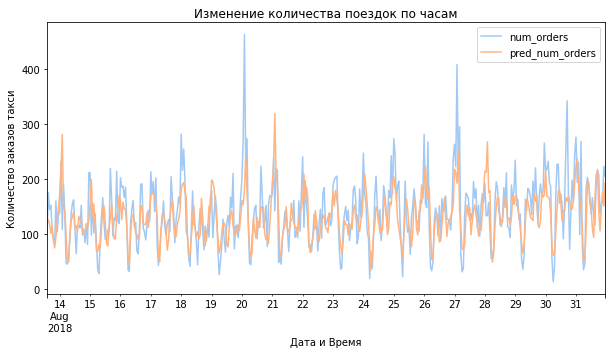

In [37]:
test[['num_orders', 'pred_num_orders' ]].plot(title='Изменение количества поездок по часам',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    figsize=(10,5))

На графике видно, что предсказания в целом хорошо соотвествуют реальным значениям таргета.

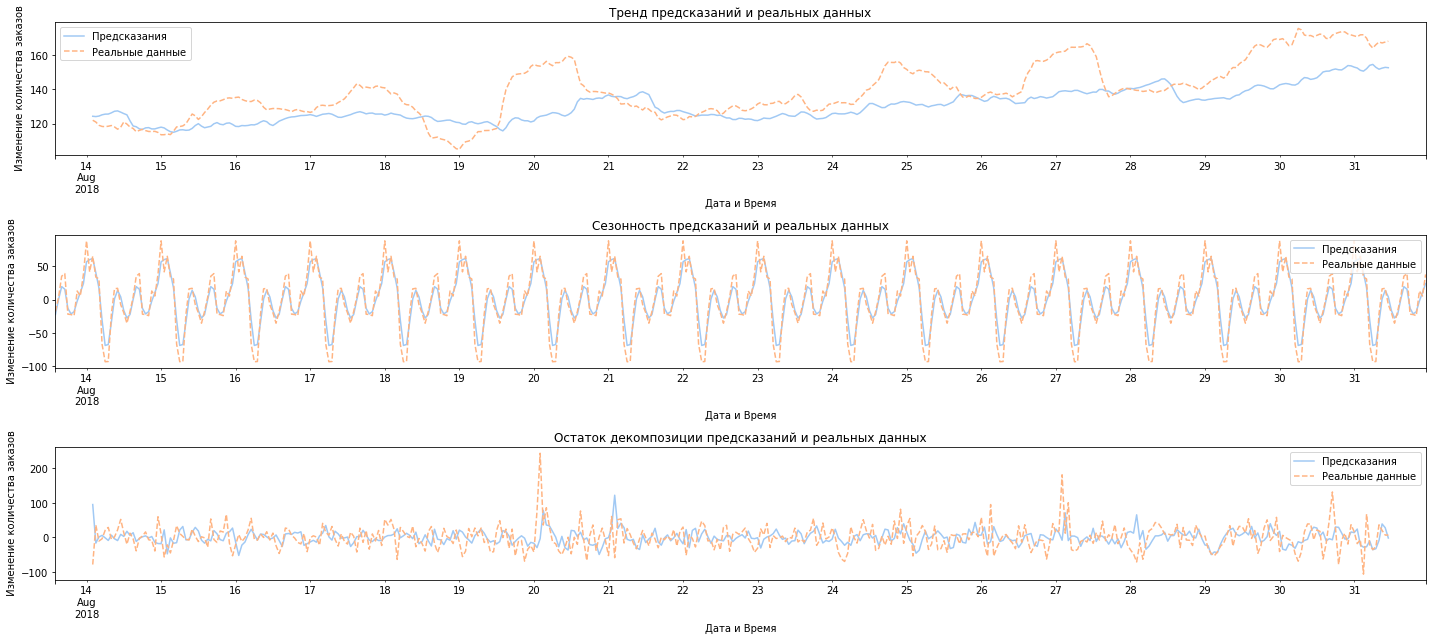

In [38]:
decomposed_pred = sm.tsa.seasonal_decompose(test['pred_num_orders'])

decomposed_actual = sm.tsa.seasonal_decompose(test['num_orders'])

plt.figure(figsize=(20, 9))


ax1 = plt.subplot(311)
decomposed_pred.trend.plot(ax=ax1, label='Предсказания')
decomposed_actual.trend.plot(ax=ax1, label='Реальные данные', linestyle='--')
plt.title('Тренд предсказаний и реальных данных')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.legend()


ax2 = plt.subplot(312)
decomposed_pred.seasonal.plot(ax=ax2, label='Предсказания')
decomposed_actual.seasonal.plot(ax=ax2, label='Реальные данные', linestyle='--')
plt.title('Сезонность предсказаний и реальных данных')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.legend()


ax3 = plt.subplot(313)
decomposed_pred.resid.plot(ax=ax3, label='Предсказания')
decomposed_actual.resid.plot(ax=ax3, label='Реальные данные', linestyle='--')
plt.title('Остаток декомпозиции предсказаний и реальных данных')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.legend()

plt.tight_layout()

Тренд и сезонность предсказаний очень похожи на изменение реальных значений признака.

Посмторим на остатки модели

<Axes: xlabel='datetime'>

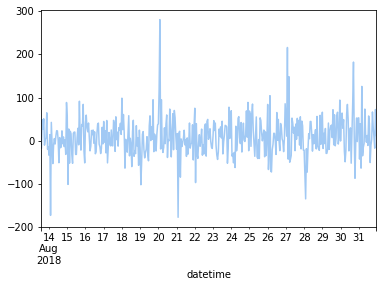

In [39]:
(test['num_orders'] - test['pred_num_orders']).plot()

### Промежуточный Вывод
- Для обучения модели и получения предсказаний добавили новые признаки:день недели, месяц, день месяца, исторические данные (отстающие значения) за предыдущие сутки и скользящее среднее по 12 значеним (не включая текущее).
- Данные стандартизовали с помощью StandardScaler и обучили модели линейной регрессии, дерева решений и модели на основе градиентного бустинга LightGBM.
- Лучшее качество при кроссвалидации было получено для бустинга LGBMRegressor(max_depth=3, n_estimators=90,learning_rate = 0.1). RMSE = 25.91.
- Для этой модели оценили качество на тестовой выборке. RMSE = 42.85. Это значение соотвествует критерию качества RMSE<48.
- Проверили адеквантна ли модель: значения ошибки RMSE равны 87.15 и 58.85 для прозноза медианой тренировочной выборки и прогноза предыдущим значеним ряда.
- По графикам определили, что предсказания в целом хорошо соотвествуют реальным значениям таргета.



### 4.4 Модели авторегрессии

Попробуем специальные модели для предсказания временных рядов

1. Prophet

In [40]:
dif_taxi_proph = dif_taxi.copy()
dif_taxi_proph.reset_index(inplace=True)
dif_taxi_proph.head()



,datetime,num_orders,num_orders_box
0,2018-03-01 01:00:00,39.0,2.147322
1,2018-03-01 02:00:00,14.0,1.775592
2,2018-03-01 03:00:00,5.0,1.254933
3,2018-03-01 04:00:00,23.0,1.971079
4,2018-03-01 05:00:00,37.0,2.131071


In [41]:
taxi_wo_first = taxi.reset_index().drop([0], axis=0).reset_index(drop=True)
taxi_wo_first.columns = ['ds','y']
taxi_wo_first.head()

,ds,y
0,2018-03-01 01:00:00,85
1,2018-03-01 02:00:00,71
2,2018-03-01 03:00:00,66
3,2018-03-01 04:00:00,43
4,2018-03-01 05:00:00,6


In [42]:
# Функция для обратного дифференцирования
def reverse_differencing(original_series, diff_series):
    # складываем поячеечно значения исходного и дифференцированного ряда
    reversed_series = diff_series.add(original_series, fill_value=0)
    return reversed_series

# Функция для обратного преобразования Бокса-Кокса
def reverse_boxcox(transformed_series, lambda_value):
    # применяем обратное преобразование к каждому значению
    reversed_series = inv_boxcox(transformed_series, lambda_value)
    return reversed_series

In [43]:
from prophet import Prophet
m = Prophet()

train, test = train_test_split(dif_taxi_proph, shuffle=False, test_size=0.1)

train_prophet = train[['datetime', 'num_orders_box']]
train_prophet.columns = ['ds', 'y']

m = Prophet()
m.fit(train_prophet)

future = m.make_future_dataframe(periods=test.shape[0], freq='H')

forecast = m.predict(future)

forecast['yhat'] = reverse_boxcox(forecast['yhat'], lmbda)
forecast['yhat_lower'] = reverse_boxcox(forecast.yhat_lower, lmbda)
forecast['yhat_upper'] = reverse_boxcox(forecast.yhat_upper, lmbda)

forecast['yhat']= reverse_differencing(taxi_wo_first['y'], forecast['yhat'])
forecast['yhat_lower'] = reverse_differencing(taxi_wo_first['y'], forecast['yhat_lower'])
forecast['yhat_upper'] = reverse_differencing(taxi_wo_first['y'], forecast['yhat_upper'])

data_with_preds  = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(taxi_wo_first.set_index('ds'))


preds = data_with_preds.yhat[-test.shape[0]:].astype(int)
y_test = data_with_preds.y[-test.shape[0]:]


print(f'Значение RMSE: {root_mean_squared_error(y_test, preds)}')


21:44:52 - cmdstanpy - INFO - Chain [1] start processing
21:44:52 - cmdstanpy - INFO - Chain [1] done processing


Значение RMSE: 4.271604655728527


Ошибку посчитали, теперь визуализируем результат.

<function matplotlib.pyplot.show(close=None, block=None)>

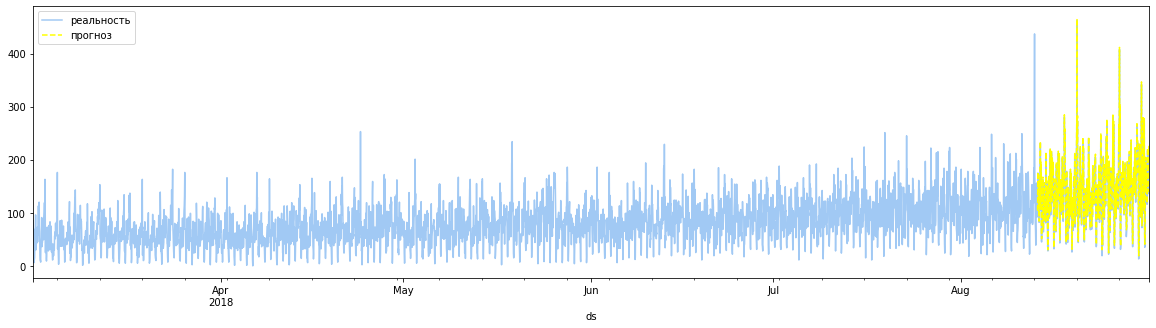

In [44]:
fig, ax = plt.subplots()

data_with_preds.y.plot(label='train', figsize=(20,5), ax=ax)
data_with_preds[-test.shape[0]:].yhat.plot(label='test', color='yellow', style='--', ax=ax)

plt.legend(['реальность', 'прогноз'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

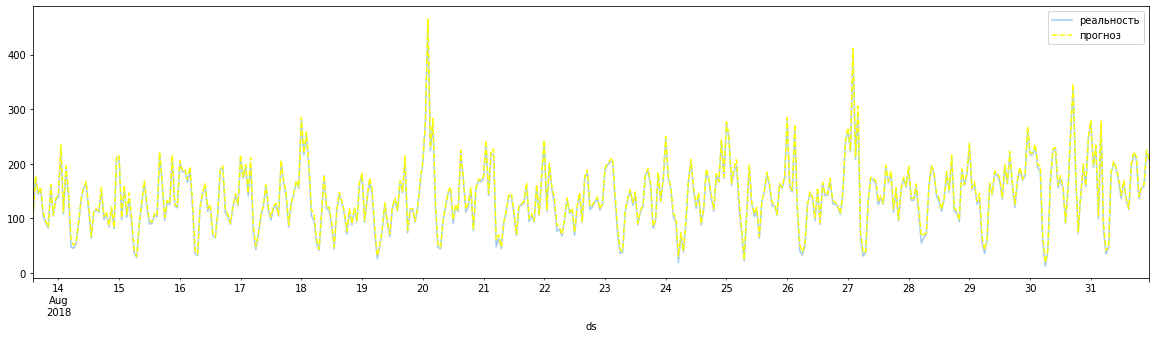

In [45]:
fig, ax = plt.subplots()

data_with_preds[-test.shape[0]:].y.plot(label='train', figsize=(20,5), ax=ax)
data_with_preds[-test.shape[0]:].yhat.plot(label='test', color='yellow', style='--', ax=ax)

plt.legend(['реальность', 'прогноз'])
plt.show

Низкое значение ошибки и графики показывают, что модель предсказала очень хорошо!

2. SARIMAX

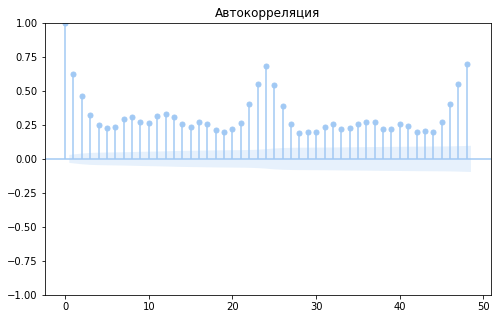

In [46]:
plt.figure(figsize=(8,5))
sm.graphics.tsa.plot_acf(taxi,ax=plt.gca(), 
                         lags =48)
plt.title('Автокорреляция')

plt.show()

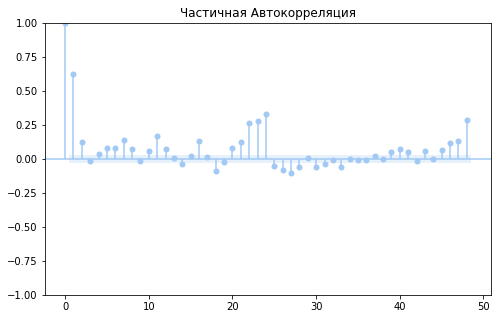

In [47]:
plt.figure(figsize=(8,5))
sm.graphics.tsa.plot_pacf(taxi,ax=plt.gca(), 
                         lags =48)
plt.title('Частичная Автокорреляция')

plt.show()

In [48]:
model=sm.tsa.statespace.SARIMAX(train['num_orders'], order=(1, 0, 1), seasonal_order=(1,0,1,24)).fit(disp=-1)
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3973
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -17981.809
Date:                            Mon, 12 Feb 2024   AIC                          35973.617
Time:                                    21:45:02   BIC                          36005.054
Sample:                                         0   HQIC                         35984.765
                                           - 3973                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2161      0.011     18.902      0.000       0.194       0.239
ma.L1         -0.9935      0.002   

In [49]:
preds = model.predict(start=len(train)+1, end=4415)
preds = preds.reset_index()

In [50]:
y_test = taxi_wo_first[-test.shape[0]:].reset_index().y

In [51]:
preds = reverse_differencing(y_test, preds.predicted_mean)

In [52]:

print(f'Значение RMSE: {round(root_mean_squared_error(y_test, preds),4)}')

Значение RMSE: 28.5436


Значение RMSE на тесте хуже, чем у Prophet, но лучше , чем у классической модели с использованием добавленных признаков.

Лучшая модель со значением **RMSE ~4** для предсказания количества заказов такси  в следующий час - **модель авторегрессии Prophet.**

## 5. Итоговый вывод исследования

1. Обзор данных
- Таблица `taxi.csv` состоит из двух столбцов - временная метка и количество заказов такси в это время. 
- В таблице 26496 записей.
- Данные соответсвуют описанию задачи.
2. Предобработка данных
- В данных нет пропусков и дубликатов
- Изменили тип данных временной отметки на `datetime`
- Ряд монотонно возрастает, временные метки упорядочены.
- Сделали ресемплирование временного ряда по одному часу (в каждой группе посчитали суммарное число заказов за час)
3. EDA
- Представлены данные с марта по август 2018 года. 
- Имеется тренд к росту числа заказов такси из аэропорта с марта по август 2018 года.
- Имеются повторяющиеся закономерности в масштабе суток: пик заказов наблюдается ночью - точнее в полночь, минимальное число заказов такси из аэропорта - рано утром , около 6 утра. Эта закономерность может быть связана, например, с режимом работы общественного транспорта (ночтю ходит реже или вообще не ходит) или предпочтениями пассажиров к времени прилета при выборе рейсов.
4. Обучение модели и предсказание

*Классическая модель + добавленные признаки*
- Для обучения модели и получения предсказаний добавили новые признаки:день недели, месяц, день месяца, исторические данные (отстающие значения) за предыдущие сутки и скользящее среднее по 12 значеним (не включая текущее).
- Данные стандартизовали с помощью StandardScaler и обучили модели линейной регрессии, дерева решений и модели на основе градиентного бустинга LightGBM.
- Лучшее качество при кроссвалидации было получено для бустинга LGBMRegressor(max_depth=3, n_estimators=90,learning_rate = 0.1). RMSE = 25.91.
- Для этой модели оценили качество на тестовой выборке. RMSE = 42.85. Это значение соотвествует критерию качества RMSE<48.
- Проверили адеквантна ли модель: значения ошибки RMSE равны 87.15 и 58.85 для прозноза медианой тренировочной выборки и прогноза предыдущим значеним ряда.
- По графикам определили, что предсказания в целом хорошо соотвествуют реальным значениям таргета.

*Prophet*
- произвели преобразование ряда в стационарный (интегрирование, преобразование Бокса-Кокса)
- метрика RMSE на тестовой выборке равна 4.27

*SARIMAX*
- модель с параметрами  pdq =101, PDQ=101, сезонность= 24 на тестововй выборке дает качество RMSE = 28.54


*Таким образом, согласно критерию по качеству, выбираем лучшей моделью для данной задачи **модель авторегрессии Prophet**. Ее качество на тестовой выборке RMSE = 4.27.*
